# State of California Solar Systems Analysis

### Import Essential Libraries

In [261]:
import operator
import os

import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"


import joblib
from sklearn.model_selection import train_test_split

from collections import Counter
from sklearn.metrics import accuracy_score, log_loss


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from scipy.stats import randint

from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

### Import DeepSolar Dataset

In [262]:
data = pd.read_csv('/Volumes/MyDisk/Spring2020/Data Mining/deepsolar_tract.csv', encoding='latin1' )
data.head()

,Unnamed: 0,tile_count,solar_system_count,total_panel_area,fips,average_household_income,county,education_bachelor,education_college,education_doctoral,...,incentive_count_nonresidential,incentive_residential_state_level,incentive_nonresidential_state_level,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate
0,0,0.0,0.0,0.000000,27145011200,70352.789869,Stearns County,569,1690,13,...,39,11,13,34,0,0,25,12,0,9.46
1,1,25.0,21.0,1133.436461,27145011301,61727.085202,Stearns County,674,1434,108,...,39,11,13,34,0,0,25,12,0,9.46
2,2,3.0,3.0,64.505776,27145011302,71496.886583,Stearns County,854,1459,31,...,39,11,13,34,0,0,25,12,0,9.46
3,3,0.0,0.0,0.000000,27145011304,86840.152755,Stearns County,640,1116,68,...,39,11,13,34,0,0,25,12,0,9.46
4,4,5.0,5.0,164.583303,27145011400,89135.315597,Stearns County,654,1314,15,...,39,11,13,34,0,0,25,12,0,9.46


In [263]:
# Checking the dimension of the data - [rows, columns]

data.shape

(72537, 169)

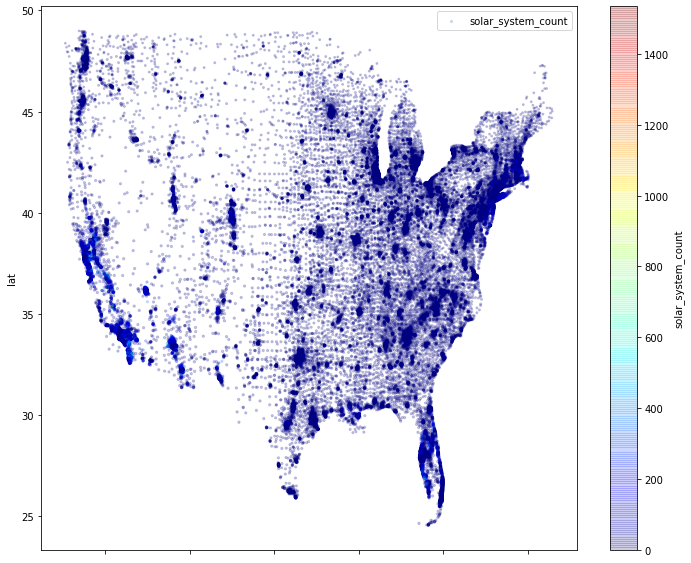

In [264]:
# LOOKING AT THE SOLAR SYSTEM COUNTS ACROSS THE UNITED STATES OF AMERICA
    # CIRCLE RADIUS REPRESENTING DAILY SOLAR RADIATION
    # COLOR REPRESENTING THE SOLAR SYSTEM COUNT - RANGING FROM DARK BLUE(low solar system count) to RED (high solar system count)
    
data.plot(kind='scatter', x='lon', y='lat', alpha=0.2, s=data['daily_solar_radiation'], 
            label = 'solar_system_count', c='solar_system_count', cmap=plt.get_cmap('jet'), colorbar=True, figsize = (12,10))
plt.legend()

        ** We can see the solar system count acorss the United Stete of America in the above plot

### Slicing to get State of California data only

In [129]:
# Slicing the dataset to reflect the State of California 

# And the checking the sliced data

cali_data = data[data['state']=='ca']
cali_data.shape

(8056, 169)

      ** In the following secton, Only State of California data is analysed.

## Census Tract Level Environmental and Socioeconomic Factors' Analysis


### 1. Statewide Incentive Parameters and Average Electricity Retail Rate Parameters

In [6]:
incentive_parameters = [

                        'incentive_count_residential',
                        'net_metering',
                        'feedin_tariff',
                        'cooperate_tax',
                        'property_tax',
                        'sales_tax',
                        'rebate',
                        'avg_electricity_retail_rate',
                        'electricity_price_residential',                                     

                       ]
len(incentive_parameters)

9

In [7]:
# Slicing the Incentive and Electricity retail rate variables and reviewing the first ten elements

cali_inc_data = cali_data[incentive_parameters]
cali_inc_data.head(10)

,incentive_count_residential,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate,electricity_price_residential
108,75,21,9,0,38,0,10,14.72,16.99
109,75,21,9,0,38,0,10,14.72,16.99
110,75,21,9,0,38,0,10,14.72,16.99
111,75,21,9,0,38,0,10,14.72,16.99
112,75,21,9,0,38,0,10,14.72,16.99
113,75,21,9,0,38,0,10,14.72,16.99
114,75,21,9,0,38,0,10,14.72,16.99
115,75,21,9,0,38,0,10,14.72,16.99
116,75,21,9,0,38,0,10,14.72,16.99
117,75,21,9,0,38,0,10,14.72,16.99


In [8]:
# Looking into missing values of California demographic variables

cali_inc_data.isnull().sum()

incentive_count_residential      0
net_metering                     0
feedin_tariff                    0
cooperate_tax                    0
property_tax                     0
sales_tax                        0
rebate                           0
avg_electricity_retail_rate      0
electricity_price_residential    0
dtype: int64

    ** The incentive variables of the State of California does not have any missing values as shown above
    
    ** Likewise, the electricity retail rate variables of the State of California does not have any missing values 

In [9]:
# For convenince, the clean incentive data slice is labeled as clean from missing values

clean_cali_inc_data = cali_inc_data.copy()
clean_cali_inc_data

,incentive_count_residential,net_metering,feedin_tariff,cooperate_tax,property_tax,sales_tax,rebate,avg_electricity_retail_rate,electricity_price_residential
108,75,21,9,0,38,0,10,14.72,16.99
109,75,21,9,0,38,0,10,14.72,16.99
110,75,21,9,0,38,0,10,14.72,16.99
111,75,21,9,0,38,0,10,14.72,16.99
112,75,21,9,0,38,0,10,14.72,16.99
...,...,...,...,...,...,...,...,...,...
70868,75,21,9,0,38,0,10,14.72,16.99
70869,75,21,9,0,38,0,10,14.72,16.99
70870,75,21,9,0,38,0,10,14.72,16.99
70871,75,21,9,0,38,0,10,14.72,16.99


### Correlations of Incentive Parameters with Solar System Count

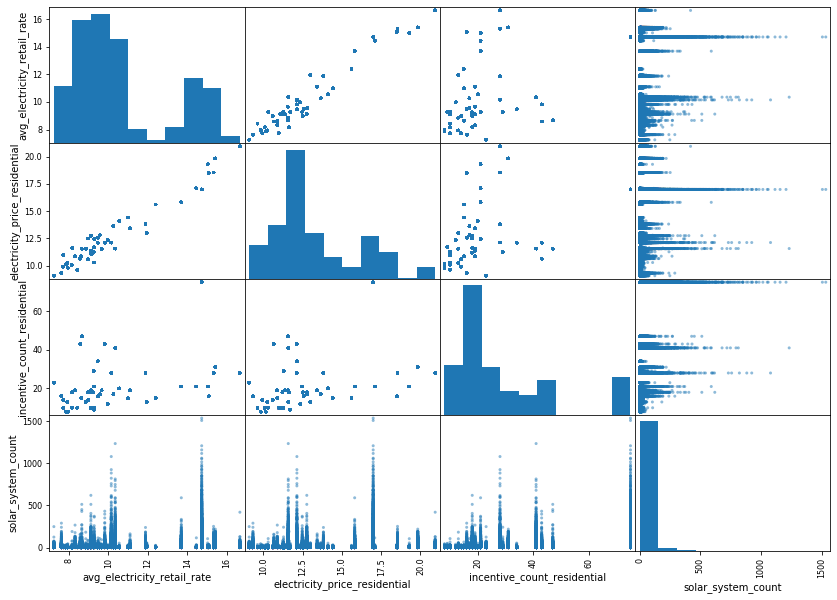

In [155]:
from pandas.plotting import scatter_matrix

attributes = ['avg_electricity_retail_rate', 'electricity_price_residential', 'incentive_count_residential', 'solar_system_count']
scatter_matrix(data[attributes], figsize=(14,10));

         ** We can observe that we have some highly correlated parameters -- to be dropped later [REDUNDANCY]
         
         ** Moreover, we can see that these parameters has some effect into the solar system count
         
         ** But the values of the parameters are constant - hence no dynamic variation and hence contribution

      ** At this stage, we have clean, without missing values, State of California incentive and electricity retail rate data
     

### 2. Statewide Demographic Parameters 

In [10]:
demographic_parameters = [
'county',
'average_household_income',
'gini_index',
'per_capita_income',                                                    
'population_density',                                                   
'education_less_than_high_school_rate',         
'education_high_school_graduate_rate',         
'education_college_rate',                       
'education_bachelor_rate',                      
'education_master_rate',                        
'education_professional_school_rate',           
'education_doctoral_rate',                      
'race_white_rate',                              
'race_black_africa_rate',                       
'race_indian_alaska_rate',                      
'race_asian_rate',                              
'race_islander_rate',                          
'race_other_rate',                              
'race_two_more_rate',
'poverty_family_below_poverty_level_rate',      
'heating_fuel_gas_rate',                        
'heating_fuel_electricity_rate',                
'heating_fuel_fuel_oil_kerosene_rate',          
'heating_fuel_coal_coke_rate',                  
'heating_fuel_solar_rate',                      
'heating_fuel_other_rate',                      
'heating_fuel_none_rate',                       
'household_count',                                
'average_household_size',                      
'housing_unit_count',                             
'housing_unit_occupied_count',                    
'housing_unit_median_value',                   
'housing_unit_median_gross_rent',
'age_18_24_rate',                               
'age_25_34_rate',                               
'age_more_than_85_rate',                        
'age_75_84_rate',                               
'age_35_44_rate',                               
'age_45_54_rate',                               
'age_65_74_rate',                               
'age_55_64_rate',                               
'age_10_14_rate',                               
'age_15_17_rate',                               
'age_5_9_rate',                                 
'household_type_family_rate',                   
'dropout_16_19_inschool_rate',                 
'occupation_construction_rate',                 
'occupation_public_rate',                       
'occupation_information_rate',                  
'occupation_finance_rate',                      
'occupation_education_rate',                    
'occupation_administrative_rate',               
'occupation_manufacturing_rate',                
'occupation_wholesale_rate',                    
'occupation_retail_rate',                       
'occupation_transportation_rate',               
'occupation_arts_rate',                        
'occupation_agriculture_rate',                  
'occupancy_vacant_rate',                        
'occupancy_owner_rate',                         
'mortgage_with_rate',                          
'transportation_home_rate',                     
'transportation_car_alone_rate',                
'transportation_walk_rate',                     
'transportation_carpool_rate',                  
'transportation_motorcycle_rate',               
'transportation_bicycle_rate',                  
'transportation_public_rate',                   
'travel_time_less_than_10_rate',               
'travel_time_10_19_rate',                       
'travel_time_20_29_rate',                       
'travel_time_30_39_rate',                       
'travel_time_40_59_rate',                       
'travel_time_60_89_rate',                       
'health_insurance_public_rate',                 
'health_insurance_none_rate',                                 
]

len(demographic_parameters)

76

In [11]:
# Slicing the demographic variables and reviewing the first ten elements

cali_demo_data = cali_data[demographic_parameters]
cali_demo_data.head(10)

,county,average_household_income,gini_index,per_capita_income,population_density,education_less_than_high_school_rate,education_high_school_graduate_rate,education_college_rate,education_bachelor_rate,education_master_rate,...,transportation_bicycle_rate,transportation_public_rate,travel_time_less_than_10_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,health_insurance_none_rate
108,Los Angeles County,88640.331010,0.4576,19648.0,11309.820,0.047858,0.225010,0.407565,0.146662,0.130838,...,0.021792,0.059322,0.164557,0.281100,0.181580,0.153208,0.165430,0.026626,0.186557,0.047268
109,Los Angeles County,99115.358593,0.4084,29555.0,8865.547,0.102294,0.203658,0.389957,0.162430,0.114693,...,0.027196,0.013375,0.096819,0.184752,0.200655,0.199252,0.230589,0.065949,0.180734,0.102952
110,Los Angeles County,414706.238185,0.5052,124712.0,2624.595,0.064271,0.149701,0.118164,0.289820,0.114970,...,0.000000,0.000610,0.212648,0.248221,0.132806,0.130435,0.109881,0.109091,0.209055,0.066238
111,Los Angeles County,107896.201580,0.5405,47022.0,11027.470,0.066475,0.269809,0.218769,0.251698,0.078411,...,0.000000,0.016873,0.128903,0.300641,0.234988,0.193755,0.121297,0.020416,0.309609,0.062601
112,Los Angeles County,123826.462548,0.5640,67095.0,12906.290,0.026752,0.119819,0.270535,0.340995,0.122080,...,0.024636,0.022956,0.143827,0.230864,0.238272,0.162346,0.200617,0.009877,0.275600,0.091574
113,Los Angeles County,50569.517885,0.4330,16951.0,12753.500,0.255090,0.337725,0.282236,0.063074,0.041118,...,0.000000,0.091563,0.046680,0.295858,0.173570,0.224195,0.101907,0.145957,0.372544,0.215128
114,Los Angeles County,130238.329911,0.5376,51988.0,9255.900,0.036670,0.097910,0.263293,0.320865,0.161349,...,0.000000,0.017277,0.141155,0.358547,0.150685,0.091721,0.159023,0.095295,0.207902,0.138690
115,Los Angeles County,102484.424449,0.4666,46837.0,19410.790,0.042698,0.113861,0.214109,0.340140,0.144802,...,0.015290,0.043455,0.134703,0.330414,0.168529,0.183026,0.175778,0.007551,0.150986,0.119670
116,Los Angeles County,62724.734694,0.4400,18892.0,8364.018,0.244304,0.290823,0.230380,0.179430,0.054114,...,0.004722,0.025184,0.018707,0.282202,0.140032,0.263495,0.176376,0.102619,0.398520,0.134559
117,Los Angeles County,198889.278901,0.5685,95105.0,10101.790,0.018913,0.043499,0.164775,0.348936,0.196217,...,0.000000,0.013936,0.165555,0.224009,0.149863,0.251079,0.130247,0.057670,0.244460,0.044316


In [12]:
# Looking into missing values of California demographic variables

cali_demo_data.isnull().sum()

county                           0
average_household_income        84
gini_index                      81
per_capita_income               50
population_density              22
                                ..
travel_time_30_39_rate          66
travel_time_40_59_rate          66
travel_time_60_89_rate          66
health_insurance_public_rate    65
health_insurance_none_rate      65
Length: 76, dtype: int64

    ** All the missing values of demographic variables in the State of California are listed above
    
    ** Considering the number of samples we have, over 8,000 samples, the number of missing values are manageable
    
    ** Hence these missing values will be filled with some values of the corresponding variable. 
    
    ** The values will be filled with the mean values of corresponding county. 
  

In [13]:
# Extracting the demographic variables with missing values

demo_var = cali_demo_data.isnull().sum() > 0
mis_val_var = demo_var[demo_var == True].keys()
mis_val_var

Index(['average_household_income', 'gini_index', 'per_capita_income',
       'population_density', 'education_less_than_high_school_rate',
       'education_high_school_graduate_rate', 'education_college_rate',
       'education_bachelor_rate', 'education_master_rate',
       'education_professional_school_rate', 'education_doctoral_rate',
       'race_white_rate', 'race_black_africa_rate', 'race_indian_alaska_rate',
       'race_asian_rate', 'race_islander_rate', 'race_other_rate',
       'race_two_more_rate', 'poverty_family_below_poverty_level_rate',
       'heating_fuel_gas_rate', 'heating_fuel_electricity_rate',
       'heating_fuel_fuel_oil_kerosene_rate', 'heating_fuel_coal_coke_rate',
       'heating_fuel_solar_rate', 'heating_fuel_other_rate',
       'heating_fuel_none_rate', 'average_household_size',
       'housing_unit_median_value', 'housing_unit_median_gross_rent',
       'age_18_24_rate', 'age_25_34_rate', 'age_more_than_85_rate',
       'age_75_84_rate', 'age_35_44_rate

In [194]:
#  Extracting State of California counties and checking them with missing demographic variable values

cali_county = cali_demo_data['county'].unique().tolist()
cali_county

['Los Angeles County',
 'San Mateo County',
 'San Joaquin County',
 'San Diego County',
 'Tuolumne County',
 'Marin County',
 'Riverside County',
 'San Francisco County',
 'Contra Costa County',
 'Butte County',
 'Orange County',
 'San Luis Obispo County',
 'San Benito County',
 'Alameda County',
 'Kern County',
 'Napa County',
 'Santa Clara County',
 'Tulare County',
 'Humboldt County',
 'Placer County',
 'Sonoma County',
 'Fresno County',
 'Monterey County',
 'Plumas County',
 'Merced County',
 'Stanislaus County',
 'Calaveras County',
 'Santa Cruz County',
 'Yuba County',
 'San Bernardino County',
 'Santa Barbara County',
 'Solano County',
 'Sacramento County',
 'Madera County',
 'Tehama County',
 'Lake County',
 'Imperial County',
 'Del Norte County',
 'Kings County',
 'Inyo County',
 'Lassen County',
 'Ventura County',
 'Nevada County',
 'Mendocino County',
 'Modoc County',
 'Colusa County',
 'El Dorado County',
 'Sutter County',
 'Alpine County',
 'Yolo County',
 'Siskiyou County

    ** In the above sections, all the demographic variables with missing values are listed,
    
    ** Moreover, all the counties with missing demographic values are listed above,
    
    ** As shown below, a function is used to fill the values with the mean values of corresponding county, 

In [15]:
# Function filling missing values of California environmental variables based on the mean of respective county

def fill_miss_data(dataset, mis_val_var, mis_val_county):
    
    # Iterate over the list of counties with missing values of environmental variables
    for i in range(len(mis_val_county)):
        
        # Slicing the dataset to a county level
        data = dataset[dataset['county'] == mis_val_county[i]]
        
        #Iterating over the missing variables with in the sliced county
        for j in range(len(mis_val_var)):
            
            var = mis_val_var[j]
            mean = data[var].mean()              # Computation of the mean value of an demographic variable
            dataset[var].fillna(mean, inplace=True) # Filling missing values with mean value of respective county
            
    return dataset

In [16]:
# Appyiing the function to fill the values and checking for missing values again

cali_demo_data = fill_miss_data(cali_demo_data, mis_val_var, cali_county)
cali_demo_data.isnull().any().any()

False

In [17]:
# Since the demographic variables do not have missing values anymore, it is labeled as clean for convenience

clean_cali_demo_data = cali_demo_data.copy()
clean_cali_demo_data.head()

,county,average_household_income,gini_index,per_capita_income,population_density,education_less_than_high_school_rate,education_high_school_graduate_rate,education_college_rate,education_bachelor_rate,education_master_rate,...,transportation_bicycle_rate,transportation_public_rate,travel_time_less_than_10_rate,travel_time_10_19_rate,travel_time_20_29_rate,travel_time_30_39_rate,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,health_insurance_none_rate
108,Los Angeles County,88640.331010,0.4576,19648.0,11309.820,0.047858,0.225010,0.407565,0.146662,0.130838,...,0.021792,0.059322,0.164557,0.281100,0.181580,0.153208,0.165430,0.026626,0.186557,0.047268
109,Los Angeles County,99115.358593,0.4084,29555.0,8865.547,0.102294,0.203658,0.389957,0.162430,0.114693,...,0.027196,0.013375,0.096819,0.184752,0.200655,0.199252,0.230589,0.065949,0.180734,0.102952
110,Los Angeles County,414706.238185,0.5052,124712.0,2624.595,0.064271,0.149701,0.118164,0.289820,0.114970,...,0.000000,0.000610,0.212648,0.248221,0.132806,0.130435,0.109881,0.109091,0.209055,0.066238
111,Los Angeles County,107896.201580,0.5405,47022.0,11027.470,0.066475,0.269809,0.218769,0.251698,0.078411,...,0.000000,0.016873,0.128903,0.300641,0.234988,0.193755,0.121297,0.020416,0.309609,0.062601
112,Los Angeles County,123826.462548,0.5640,67095.0,12906.290,0.026752,0.119819,0.270535,0.340995,0.122080,...,0.024636,0.022956,0.143827,0.230864,0.238272,0.162346,0.200617,0.009877,0.275600,0.091574


     ** At this part of the project, the State of California demographical variables do not have missing values
     
     ** Clean California demographical variables

### Correlations of Selected Demographic Parameters with Solar System Count

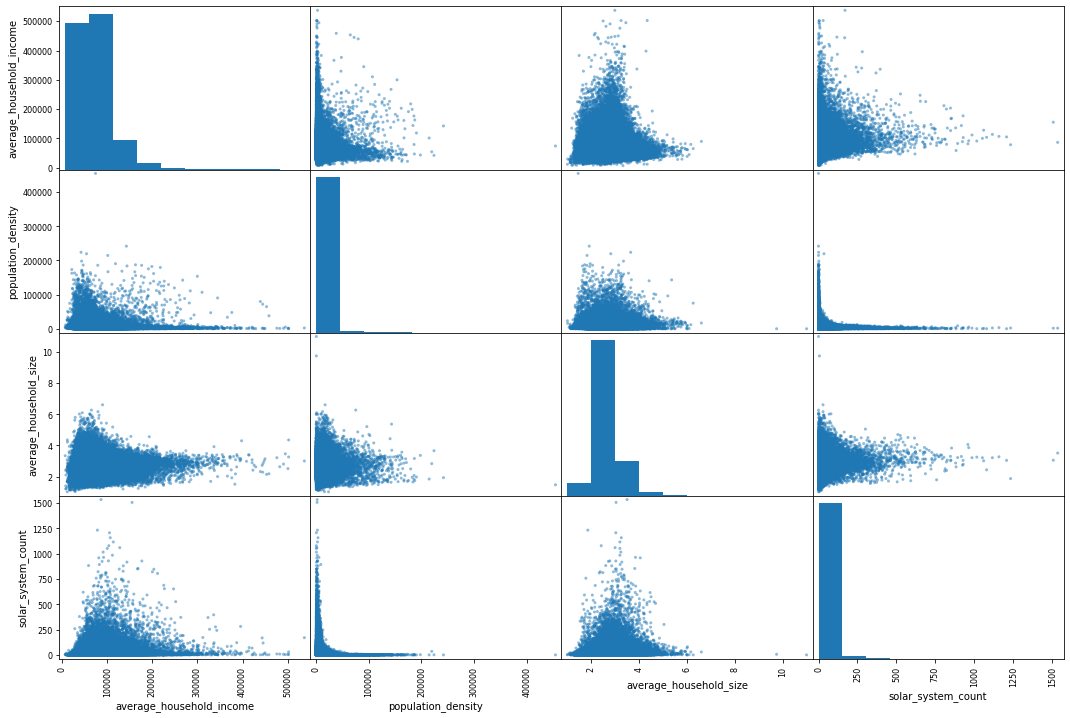

In [157]:
attributes = ['average_household_income', 'population_density', 'average_household_size', 'solar_system_count']
scatter_matrix(data[attributes], figsize=(18,12));

### 3. Statewide Environmental Condition Parameters

In [18]:
envt_parameters = [
    'county',
'heating_design_temperature',                  
'cooling_design_temperature',                  
'earth_temperature_amplitude',             
'frost_days',                                 
'air_temperature',                             
'relative_humidity',                          
'daily_solar_radiation',                       
'atmospheric_pressure',                        
'wind_speed',                                 
'earth_temperature',                           
'heating_degree_days',                         
'cooling_degree_days',
]
len(envt_parameters)

13

In [19]:
# Slicing the dataset to reflect the envornmental variables/parameters

cali_envt_data = cali_data[envt_parameters]
cali_envt_data.head(10)

,county,heating_design_temperature,cooling_design_temperature,earth_temperature_amplitude,frost_days,air_temperature,relative_humidity,daily_solar_radiation,atmospheric_pressure,wind_speed,earth_temperature,heating_degree_days,cooling_degree_days
108,Los Angeles County,7.39,28.26,13.18,0.0,17.6,0.515,5.20,98.6,4.6,19.5,767.0,2841.0
109,Los Angeles County,7.39,28.26,13.18,0.0,17.6,0.515,5.20,98.6,4.6,19.5,767.0,2841.0
110,Los Angeles County,2.35,33.22,22.20,3.0,17.2,0.401,5.41,94.7,4.4,19.8,1208.0,2815.0
111,Los Angeles County,2.35,33.22,22.20,3.0,17.2,0.401,5.41,94.7,4.4,19.8,1208.0,2815.0
112,Los Angeles County,2.35,33.22,22.20,3.0,17.2,0.401,5.41,94.7,4.4,19.8,1208.0,2815.0
113,Los Angeles County,7.39,28.26,13.18,0.0,17.6,0.515,5.20,98.6,4.6,19.5,767.0,2841.0
114,Los Angeles County,2.35,33.22,22.20,3.0,17.2,0.401,5.41,94.7,4.4,19.8,1208.0,2815.0
115,Los Angeles County,2.35,33.22,22.20,3.0,17.2,0.401,5.41,94.7,4.4,19.8,1208.0,2815.0
116,Los Angeles County,2.35,33.22,22.20,3.0,17.2,0.401,5.41,94.7,4.4,19.8,1208.0,2815.0
117,Los Angeles County,2.35,33.22,22.20,3.0,17.2,0.401,5.41,94.7,4.4,19.8,1208.0,2815.0


In [20]:
# Checking missing values of California environmental variables

cali_envt_data.isnull().sum() 

county                          0
heating_design_temperature     16
cooling_design_temperature     16
earth_temperature_amplitude    16
frost_days                     16
air_temperature                16
relative_humidity              16
daily_solar_radiation          16
atmospheric_pressure           16
wind_speed                     16
earth_temperature              16
heating_degree_days            16
cooling_degree_days            16
dtype: int64

In [21]:
# The fact they all have the same number of missing values implies they might be missing from the same places

# USING ONE OF THE VARIABLES  to check if the missing values are from the same places

# It is here shown that all the missing values are from the same places of different counties

cali_envt_data[cali_envt_data['wind_speed'].isnull() == True]

,county,heating_design_temperature,cooling_design_temperature,earth_temperature_amplitude,frost_days,air_temperature,relative_humidity,daily_solar_radiation,atmospheric_pressure,wind_speed,earth_temperature,heating_degree_days,cooling_degree_days
633,Los Angeles County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
635,Los Angeles County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4539,San Mateo County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8229,San Diego County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14157,Marin County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17791,San Francisco County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17979,Contra Costa County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19220,Orange County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19966,San Luis Obispo County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23017,Alameda County,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Listing the counties in the State of California with missing environmental variable values

mis_val_county = cali_envt_data[cali_envt_data['wind_speed'].isnull() == True]['county'].unique().tolist()
mis_val_county

['Los Angeles County',
 'San Mateo County',
 'San Diego County',
 'Marin County',
 'San Francisco County',
 'Contra Costa County',
 'Orange County',
 'San Luis Obispo County',
 'Alameda County',
 'Humboldt County',
 'Sonoma County',
 'Monterey County',
 'Santa Cruz County',
 'Del Norte County',
 'Mendocino County']

In [23]:
# These are the environmental variables with missing values in the State of California

mis_val_var = envt_parameters[1:]
mis_val_var

['heating_design_temperature',
 'cooling_design_temperature',
 'earth_temperature_amplitude',
 'frost_days',
 'air_temperature',
 'relative_humidity',
 'daily_solar_radiation',
 'atmospheric_pressure',
 'wind_speed',
 'earth_temperature',
 'heating_degree_days',
 'cooling_degree_days']

    ** As shown in the above , we have 16 missing values from each of those environmental variables listed above,
    
    ** Those missing values belong to different counties,
    
    ** Hence, the mean values of corresponding county are used to fill the missing values.

In [24]:
# Running the previous function to fill the missing values and checking for missing values again

cali_envt_data = fill_miss_data(cali_envt_data, mis_val_var, mis_val_county )
cali_envt_data.isnull().sum()

county                         0
heating_design_temperature     0
cooling_design_temperature     0
earth_temperature_amplitude    0
frost_days                     0
air_temperature                0
relative_humidity              0
daily_solar_radiation          0
atmospheric_pressure           0
wind_speed                     0
earth_temperature              0
heating_degree_days            0
cooling_degree_days            0
dtype: int64

In [25]:
# Finalize and copy the clean environmental variables and labeling it as clean

clean_cali_envt_data = cali_envt_data.copy()
clean_cali_envt_data.head()

,county,heating_design_temperature,cooling_design_temperature,earth_temperature_amplitude,frost_days,air_temperature,relative_humidity,daily_solar_radiation,atmospheric_pressure,wind_speed,earth_temperature,heating_degree_days,cooling_degree_days
108,Los Angeles County,7.39,28.26,13.18,0.0,17.6,0.515,5.20,98.6,4.6,19.5,767.0,2841.0
109,Los Angeles County,7.39,28.26,13.18,0.0,17.6,0.515,5.20,98.6,4.6,19.5,767.0,2841.0
110,Los Angeles County,2.35,33.22,22.20,3.0,17.2,0.401,5.41,94.7,4.4,19.8,1208.0,2815.0
111,Los Angeles County,2.35,33.22,22.20,3.0,17.2,0.401,5.41,94.7,4.4,19.8,1208.0,2815.0
112,Los Angeles County,2.35,33.22,22.20,3.0,17.2,0.401,5.41,94.7,4.4,19.8,1208.0,2815.0


## Correlations of Selected Environmental Parameters with Solar System Count

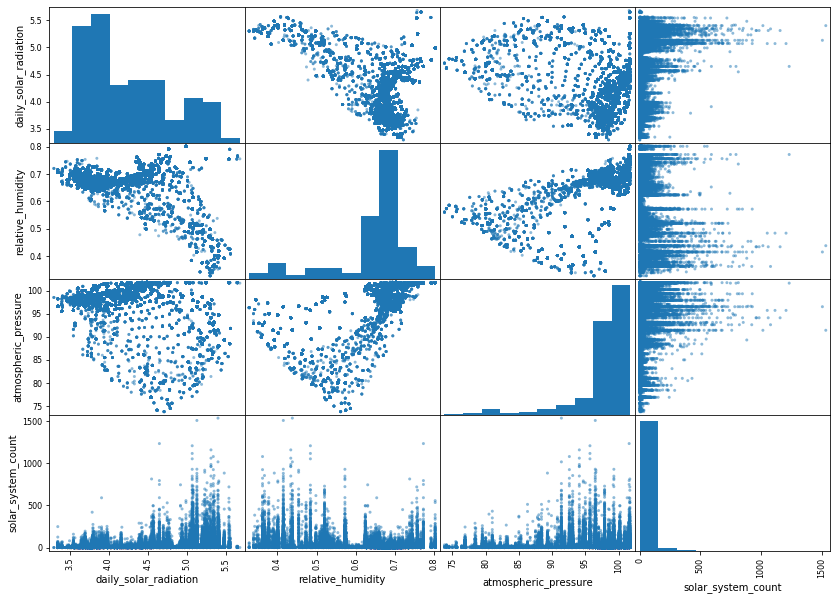

In [158]:
attributes = ['daily_solar_radiation', 'relative_humidity', 'atmospheric_pressure', 'solar_system_count']
scatter_matrix(data[attributes], figsize=(14,10));

        ** In the above visual presentation - we can observe some correlations among various parameters

     ** At this stage of the implementation, the California environemental variables do not have missing values
     ** Clean California environmental data

### 4. Statewide Political Views Parameters


In [26]:
pol_parameters = [
    
'voting_2016_dem_percentage',                     
'voting_2016_gop_percentage',                     
'voting_2016_dem_win',                            
'voting_2012_dem_percentage',                 
'voting_2012_gop_percentage',                
'voting_2012_dem_win'                           
]

len(pol_parameters)

6

In [27]:
# Looking into the missing values of Poltical view data values in the State of California

# As shown here below, this part of the dataset fortunately does not have missing values

cali_pol_data = cali_data[pol_parameters]
cali_pol_data.isnull().sum()

voting_2016_dem_percentage    0
voting_2016_gop_percentage    0
voting_2016_dem_win           0
voting_2012_dem_percentage    0
voting_2012_gop_percentage    0
voting_2012_dem_win           0
dtype: int64

In [28]:
# However, mapping the True and False value to a corresponding binary variables enhances applying computations

# Mapping True and False values of our attributes into 1 and 0 respectively

vot_map = {True: 1, False: 0}

cali_pol_data['voting_2016_dem_win'] = cali_pol_data['voting_2016_dem_win'].map(vot_map)
cali_pol_data['voting_2012_dem_win'] = cali_pol_data['voting_2016_dem_win'].map(vot_map)
cali_pol_data.head()

,voting_2016_dem_percentage,voting_2016_gop_percentage,voting_2016_dem_win,voting_2012_dem_percentage,voting_2012_gop_percentage,voting_2012_dem_win
108,0.714072,0.233887,1,0.689,0.288,1
109,0.714072,0.233887,1,0.689,0.288,1
110,0.714072,0.233887,1,0.689,0.288,1
111,0.714072,0.233887,1,0.689,0.288,1
112,0.714072,0.233887,1,0.689,0.288,1


In [29]:
# Finalize and copy the clean political variables and labeling it as clean

clean_cali_pol_data = cali_pol_data.copy()
clean_cali_pol_data

,voting_2016_dem_percentage,voting_2016_gop_percentage,voting_2016_dem_win,voting_2012_dem_percentage,voting_2012_gop_percentage,voting_2012_dem_win
108,0.714072,0.233887,1,0.689,0.288,1
109,0.714072,0.233887,1,0.689,0.288,1
110,0.714072,0.233887,1,0.689,0.288,1
111,0.714072,0.233887,1,0.689,0.288,1
112,0.714072,0.233887,1,0.689,0.288,1
...,...,...,...,...,...,...
70868,0.326794,0.617123,0,0.358,0.613,0
70869,0.326794,0.617123,0,0.358,0.613,0
70870,0.326794,0.617123,0,0.358,0.613,0
70871,0.326794,0.617123,0,0.358,0.613,0


## Corrlations of Selected Political Parameters with Solar System Count

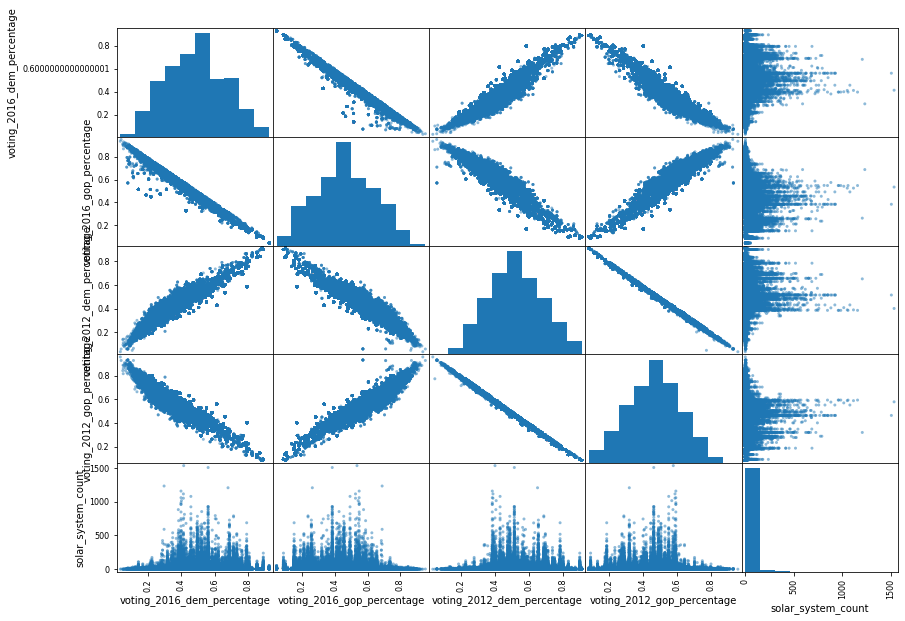

In [159]:
attributes = ['voting_2016_dem_percentage', 'voting_2016_gop_percentage', 'voting_2012_dem_percentage', 'voting_2012_gop_percentage', 'solar_system_count']
scatter_matrix(data[attributes], figsize=(14,10));

        ** We can observe great correlations among the attributes and little with the solar system count

      * The political views variables from the State of California is clean and ready to be processed at this stage

## Merging Clean Environmental and Socio-economic Dataset Slices

In [572]:
# To perform computations on all the slices combined, all the slices are merged at this section

# Moreover, the dimensions of the dataset are also checked for consistency

slices = [clean_cali_inc_data, clean_cali_demo_data, clean_cali_envt_data, clean_cali_pol_data]
dataset = pd.concat(slices, axis=1, sort=False)
dataset.drop('county', axis=1, inplace=True)
dataset.shape

(8056, 102)

In [573]:
# Further checking for missing values and consistency checking

dataset.isnull().sum()

incentive_count_residential    0
net_metering                   0
feedin_tariff                  0
cooperate_tax                  0
property_tax                   0
                              ..
voting_2016_gop_percentage     0
voting_2016_dem_win            0
voting_2012_dem_percentage     0
voting_2012_gop_percentage     0
voting_2012_dem_win            0
Length: 102, dtype: int64

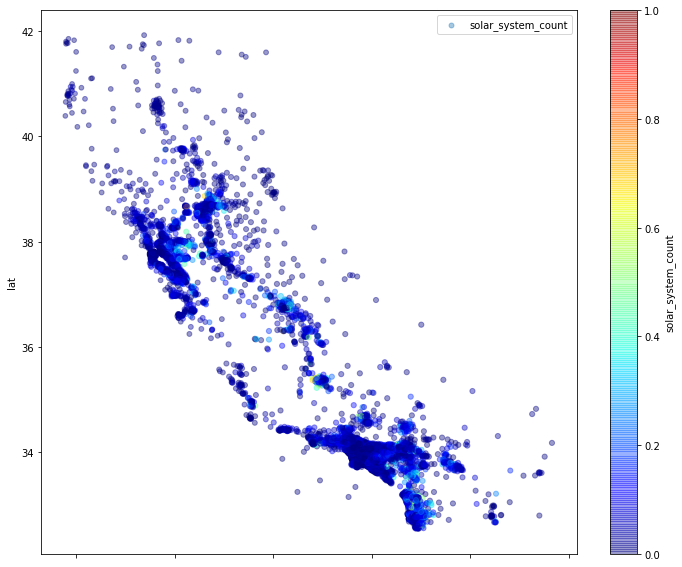

In [574]:
# LOOKING AT THE SOLAR SYSTEM COUNTS ACORSS THE STATE OF CALIFORNIA
    # CIRCLE RADIUS REPRESENTING DAILY SOLAR RADIATION  ** SCALED BY 5 FOLD FOR VISUALIZATION PURPOSES
    # COLOR REPRESENTING SOLAR SYSTEM COUNT  - RANGING FROM DARK BLUE(low solar system count) to RED (high count)

df = data[data['state'] == 'ca']

## Normalizing the solar system count parameter only for visualization purposes
df['solar_system_count']=((df['solar_system_count']-df['solar_system_count'].min())/(df['solar_system_count'].max()-df['solar_system_count'].min()))

df.plot(kind='scatter', x='lon', y='lat', alpha=0.4, s=df['daily_solar_radiation']*5, # Scaling solar radiation for visualizationn purposes
            label = 'solar_system_count', c='solar_system_count', cmap=plt.get_cmap('jet'), colorbar=True, figsize = (12,10))
plt.legend()

       ** We can obserse from the above distribution that south side of the State of California has relatively lower solar system count
       
       ** And considering the fact that the radius of of the data points represent daily solar radiation,  we can see from the above plot that most of the areas get relatively same daily solar radiation

     ** At this stage, the environmental and socio-economic variables reflecting the State of California are clean and ready for further regression or classification processing

  --------------------------------------------------------------------------------------------------------------
    
    ** In the following section, a classification algorithm is applied to the clean dataset
    
    ** This algorithm will classify area with/without solar panels installed

# Classification

###     A.   Feature Selection 

      ** Upto this stage, we have been cleaning socio-economic dataset for missing values in State of California 
      
      ** This clean State of California's socio-economic dataset contains 8056 data records with 102 dimensions
      
      ** Feature selection is applied at this stage to drop features with little contribution for classification 

### 1.  Variance Based 

In [575]:
# Removing features with zero standard deviation - having values that does not change 

print("Original dataset shape - ", dataset.shape)

# Remove Constant Features
constant_features = [feat for feat in dataset.columns if (dataset[feat].std() == 0 or dataset[feat].min() == dataset[feat].max())]

print('\nThe following features have constant with little contribution for classification, Hence they are dropped \n\n', constant_features)
print('\n')

# Dropping all the data with constant values 

dataset.drop(labels=constant_features, axis=1, inplace=True)
print("Reduced feature California socio economic dataset shape -",dataset.shape)

Original dataset shape -  (8056, 102)

The following features have constant with little contribution for classification, Hence they are dropped 

 ['incentive_count_residential', 'net_metering', 'feedin_tariff', 'cooperate_tax', 'property_tax', 'sales_tax', 'rebate', 'avg_electricity_retail_rate', 'electricity_price_residential']


Reduced feature California socio economic dataset shape - (8056, 93)


### 2. Correlation Based

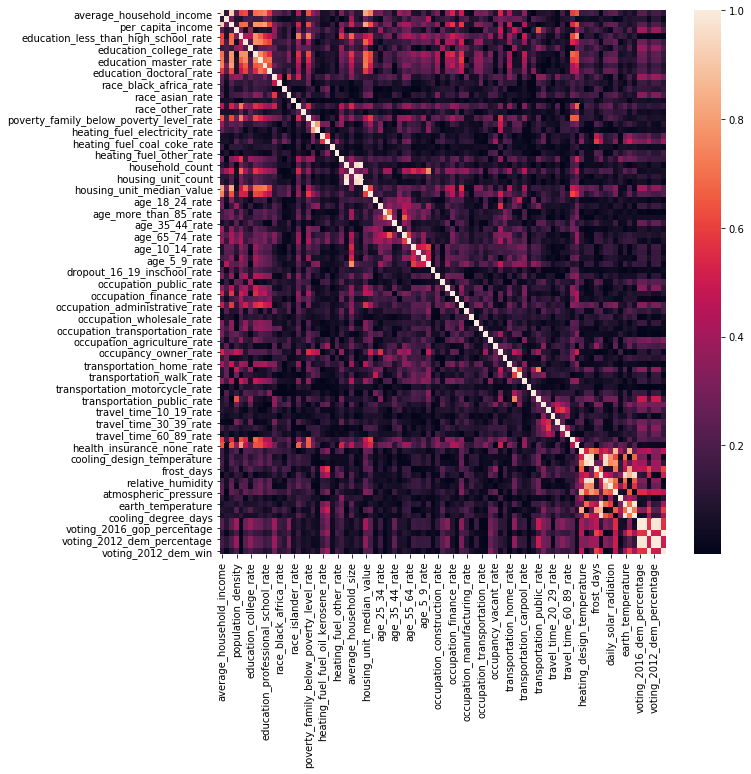

In [576]:
# Looking into the correlation among parameters using a heat map

import seaborn as sns
corr_matrix = dataset.corr().abs()
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix)

In [577]:
# Further reduction of the variables based on the correlations of parameters  - Creating redundancy

# Dropping parameters which has paramters with correlation of 0.7 or higher with other parameters

columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j] >= 0.7:
            if columns[j]:
                columns[j] = False
selected_columns = dataset.columns[columns]
dataset = dataset[selected_columns]
dataset.shape

(8056, 67)

### Feature Creation

In [578]:
# Including the solar system count to the dataset for correlation comparison purpose

dataset['solar_system_count'] = data['solar_system_count'][dataset.index]

In [579]:
# Looking into correlation of top 50 parameters with the target value

corr= dataset.corr().abs()
corr['solar_system_count'].sort_values(ascending=False)[:50]

solar_system_count                      1.000000
occupancy_owner_rate                    0.452397
household_count                         0.409789
average_household_income                0.326615
population_density                      0.301723
education_less_than_high_school_rate    0.281846
age_25_34_rate                          0.268769
heating_fuel_gas_rate                   0.265068
health_insurance_public_rate            0.261992
transportation_car_alone_rate           0.257558
heating_fuel_none_rate                  0.244529
occupation_arts_rate                    0.220584
heating_fuel_solar_rate                 0.199739
voting_2016_dem_percentage              0.192716
race_white_rate                         0.192372
mortgage_with_rate                      0.191960
transportation_walk_rate                0.189220
age_10_14_rate                          0.179594
age_45_54_rate                          0.174883
occupation_finance_rate                 0.174067
education_college_ra

In [580]:
# In this section, new parameters are created that have higher correlation with the target than one of original constitutient

# wind_to_air_temperature_rate has higher correlation with solar system count than air temperature and wind speed
# avg_household_income_per_size has higher correlation with solar system count than average household size

wind_to_air_temperature_rate = dataset['wind_speed']/dataset['air_temperature']
avg_household_income_per_size = dataset['average_household_income']/dataset['average_household_size']

# MAKING THE NEW PARAMETERS IN CAPITAL LETTER SO THAT THEY ARE EASIER TO SPOT
dataset['WIND_TO_AIR_TEMPERATURE_RATE'] = wind_to_air_temperature_rate
dataset['AVG_HOUSEHOLD_INCOME_PER_SIZE '] = avg_household_income_per_size 
corr= dataset.corr().abs()
corr['solar_system_count'].sort_values(ascending=False)[:60]


solar_system_count                      1.000000
occupancy_owner_rate                    0.452397
household_count                         0.409789
average_household_income                0.326615
population_density                      0.301723
education_less_than_high_school_rate    0.281846
age_25_34_rate                          0.268769
heating_fuel_gas_rate                   0.265068
health_insurance_public_rate            0.261992
transportation_car_alone_rate           0.257558
heating_fuel_none_rate                  0.244529
occupation_arts_rate                    0.220584
AVG_HOUSEHOLD_INCOME_PER_SIZE           0.213062
heating_fuel_solar_rate                 0.199739
voting_2016_dem_percentage              0.192716
race_white_rate                         0.192372
mortgage_with_rate                      0.191960
transportation_walk_rate                0.189220
age_10_14_rate                          0.179594
age_45_54_rate                          0.174883
occupation_finance_r

In [581]:
# IN THIS SECTION, DROPPING THE LOWER CORRELATION PARAMETERS THAT ARE CONSTITUTIENTS OF THE NEW PARAMETERS

# MOREOVER, DROPPING THE TARGET VALUE, SOLAR SYSTEM COUNT, FOR FURTHER COMPUTATION ON OUR PARAMETERS

dataset.drop(['average_household_size', 'solar_system_count', 'air_temperature', 'wind_speed'], axis=1, inplace=True)
dataset[~np.isfinite( dataset )] = 0 

In [582]:
dataset.shape

(8056, 66)

     ** At this stage - Significant feature selection and feature creation has been carried out 
     
     ** Data distribution has of the parameters has major proportional difference among them
     
     ** For example, average_household_income max value is 537130.22, however gini_index has max value of 0.73. 
     
     ** Since proportion difference leads our classifier for possible bias, normalization is crucial for the data

### B. Dataset Normalization

In [583]:
## Applying min max normalization to the dataset

# This normalization technique will normalize the values and retain our dataset distribution 

data_norm=((dataset-dataset.min())/(dataset.max()-dataset.min()))
data_norm.head()

,average_household_income,gini_index,population_density,education_less_than_high_school_rate,education_high_school_graduate_rate,education_college_rate,race_white_rate,race_black_africa_rate,race_indian_alaska_rate,race_asian_rate,...,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,heating_design_temperature,cooling_design_temperature,frost_days,voting_2016_dem_percentage,voting_2016_dem_win,WIND_TO_AIR_TEMPERATURE_RATE,AVG_HOUSEHOLD_INCOME_PER_SIZE
108,0.150732,0.618723,0.065249,0.047858,0.430530,0.407565,0.658069,0.015244,0.004775,0.180700,...,0.165430,0.026626,0.186557,0.857143,0.530498,0.000000,0.779965,1.0,0.274772,0.132572
109,0.170568,0.550285,0.051147,0.102294,0.389676,0.389957,0.652914,0.034470,0.000000,0.136572,...,0.230589,0.065949,0.180734,0.857143,0.530498,0.000000,0.779965,1.0,0.274772,0.144289
110,0.768176,0.684935,0.015142,0.064271,0.286435,0.118164,0.853829,0.011941,0.000000,0.062435,...,0.109881,0.109091,0.209055,0.519115,0.808058,0.022727,0.779965,1.0,0.257042,0.677940
111,0.187196,0.734038,0.063620,0.066475,0.516248,0.218769,0.814982,0.018515,0.007094,0.111381,...,0.121297,0.020416,0.309609,0.519115,0.808058,0.022727,0.779965,1.0,0.257042,0.241356
112,0.217361,0.766727,0.074459,0.026752,0.229260,0.270535,0.801053,0.005921,0.003306,0.151220,...,0.200617,0.009877,0.275600,0.519115,0.808058,0.022727,0.779965,1.0,0.257042,0.355150


In [584]:
# Looking into distribution of data in all variables

data_norm.describe()

,average_household_income,gini_index,population_density,education_less_than_high_school_rate,education_high_school_graduate_rate,education_college_rate,race_white_rate,race_black_africa_rate,race_indian_alaska_rate,race_asian_rate,...,travel_time_40_59_rate,travel_time_60_89_rate,health_insurance_public_rate,heating_design_temperature,cooling_design_temperature,frost_days,voting_2016_dem_percentage,voting_2016_dem_win,WIND_TO_AIR_TEMPERATURE_RATE,AVG_HOUSEHOLD_INCOME_PER_SIZE
count,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,...,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000,8056.000000
mean,0.144660,0.567060,0.049617,0.190524,0.399291,0.294265,0.623674,0.066963,0.009757,0.144905,...,0.123891,0.074393,0.330656,0.610908,0.643488,0.037269,0.634277,0.918942,0.236466,0.151068
std,0.082833,0.083271,0.055680,0.159264,0.153796,0.090287,0.205916,0.103633,0.022006,0.165631,...,0.063679,0.052737,0.125534,0.173457,0.178526,0.092189,0.191797,0.272940,0.099603,0.107017
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.088346,0.511337,0.015402,0.062448,0.292040,0.231739,0.479149,0.010021,0.000000,0.031634,...,0.077156,0.034735,0.238216,0.519115,0.530498,0.000000,0.461437,1.000000,0.155545,0.073833
50%,0.126384,0.561552,0.036438,0.140160,0.409216,0.295907,0.660350,0.030880,0.004049,0.087624,...,0.119831,0.066113,0.320872,0.606304,0.683828,0.000000,0.676510,1.000000,0.222601,0.125197
75%,0.178792,0.613854,0.063722,0.283611,0.510778,0.357706,0.789439,0.079074,0.011835,0.188667,...,0.163661,0.102477,0.411080,0.763917,0.808058,0.022727,0.779965,1.000000,0.274772,0.197715
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


    ** The dataset is normalized using min-max normalization as shown and retains previous distribution 
    
    ** Furthermore, min-max retains information embedded in the dataset

In [585]:
# Extracting the indices of each data record in the normalized data

# These indices will help in assigning labels to each data record

ind = data_norm.index

In [586]:
# The Solar_System_Count is used as a label for our dataset 

      #.  solar_system_count > 0,  label = 0
      #.  solar_system_count = 0,  label = 0

labels = data['solar_system_count'][ind].values
labels = np.where(labels > 0, 1, 0)
labels

array([1, 1, 1, ..., 0, 1, 0])

In [587]:
# Checking if the number of labels is equal to the number of records

# As shown below, the number of labels match the number of data records

print("The dataset has", data_norm.shape[0], "data records.")
print("The labels array has", len(labels), "labels.")

The dataset has 8056 data records.
The labels array has 8056 labels.


### C. Splitting the dataset into Train and Validation Subsets

     ** In this section, the dataset is split into train, validation and test subsets
     
                 ^^. 80% training subset
                 ^^. 20% validation subset

In [588]:
# split into training and validations subsets

# First splitting the dataset into 60% train and 40% validation

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(data_norm, labels, test_size = 0.2, random_state = 42, shuffle = True, stratify = labels)

In [589]:
# A function to print the accuracy results for every combination of parameters we will use for our classfier

def print_results(results):
    print("Best Params: {}\n".format(results.best_params_))   
    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print('{} (+/-{}) for {}'.format(round(mean,3), round(std*2, 3), params))

## Training A Classification Algorithm

       ** Feeding the data records to classify areas with and without a solar system
       
       ** Comparing Random Forest Classifier and Support Vector Machine for our dataset

## SVC

In [398]:
svc = SVC()
parameters = { 'kernel': ['linear','rbf', 'poly'], 'C': [0.1, 1, 10, 100]}

cv = GridSearchCV(svc, parameters, cv=10)
cv.fit(X_train, y_train)

print_results(cv)

Best Params: {'C': 100, 'kernel': 'linear'}

0.969 (+/-0.001) for {'C': 0.1, 'kernel': 'linear'}
0.969 (+/-0.001) for {'C': 0.1, 'kernel': 'rbf'}
0.969 (+/-0.001) for {'C': 0.1, 'kernel': 'poly'}
0.969 (+/-0.001) for {'C': 1, 'kernel': 'linear'}
0.969 (+/-0.001) for {'C': 1, 'kernel': 'rbf'}
0.972 (+/-0.006) for {'C': 1, 'kernel': 'poly'}
0.973 (+/-0.008) for {'C': 10, 'kernel': 'linear'}
0.973 (+/-0.008) for {'C': 10, 'kernel': 'rbf'}
0.972 (+/-0.01) for {'C': 10, 'kernel': 'poly'}
0.974 (+/-0.008) for {'C': 100, 'kernel': 'linear'}
0.97 (+/-0.006) for {'C': 100, 'kernel': 'rbf'}
0.965 (+/-0.007) for {'C': 100, 'kernel': 'poly'}


In [399]:
# Prediction
val_prediction = cv.predict(X_validation)

In [400]:
# VALIDATION DATA ACCURACY

print('Accuracy score for validation Dataset = ', accuracy_score(y_validation, val_prediction))

Accuracy score for validation Dataset =  0.9751861042183623


## Random Forest

In [590]:
rf = RandomForestClassifier()
parameters = {
    'n_estimators': [300, 500,1000],
    'max_depth': [32,None],
    'max_features': [2, 4, 10],
    
    
}

cv = GridSearchCV(rf, parameters, cv=10, scoring='accuracy')
cv.fit(X_train, y_train)


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [591]:
print_results(cv)

Best Params: {'max_depth': None, 'max_features': 10, 'n_estimators': 500}

0.972 (+/-0.004) for {'max_depth': 32, 'max_features': 2, 'n_estimators': 300}
0.972 (+/-0.004) for {'max_depth': 32, 'max_features': 2, 'n_estimators': 500}
0.972 (+/-0.003) for {'max_depth': 32, 'max_features': 2, 'n_estimators': 1000}
0.973 (+/-0.005) for {'max_depth': 32, 'max_features': 4, 'n_estimators': 300}
0.973 (+/-0.005) for {'max_depth': 32, 'max_features': 4, 'n_estimators': 500}
0.974 (+/-0.005) for {'max_depth': 32, 'max_features': 4, 'n_estimators': 1000}
0.974 (+/-0.007) for {'max_depth': 32, 'max_features': 10, 'n_estimators': 300}
0.974 (+/-0.006) for {'max_depth': 32, 'max_features': 10, 'n_estimators': 500}
0.974 (+/-0.006) for {'max_depth': 32, 'max_features': 10, 'n_estimators': 1000}
0.972 (+/-0.003) for {'max_depth': None, 'max_features': 2, 'n_estimators': 300}
0.972 (+/-0.002) for {'max_depth': None, 'max_features': 2, 'n_estimators': 500}
0.972 (+/-0.002) for {'max_depth': None, 'max_

In [592]:
target = ['Without solar', 'With solar']

In [593]:
# PREDICTION ON VALIDATION DATA

val_prediction = cv.predict(X_validation)

In [594]:
# VALIDATION DATA ACCURACY

#  We have got same accuracy for our validation data - the model is performing great

print('Accuracy score for Testing Dataset = ', accuracy_score(y_validation, val_prediction))

Accuracy score for Testing Dataset =  0.9764267990074442


In [595]:
filename = 'solar_classification_model.sav'

In [596]:
# save the model to disk


joblib.dump(cv, filename)

['solar_classification_model.sav']

In [597]:
# Load the model from the disk

cv = joblib.load(filename)

In [598]:
# Prediction on the total data for checking

tot_prediction = cv.predict(data_norm)

In [599]:
# Accuracy on the tatal data 
print('Accuracy score for Testing Dataset = ', accuracy_score(tot_prediction, labels))

Accuracy score for Testing Dataset =  0.9950347567030785


In [600]:
# COPYING NORMALIZED DATA TO REFLECT CLASSIFIED DATA

class_data =data_norm.copy()
class_data.shape

(8056, 66)

In [601]:
# Dataset after prediction

# Extracting the values with zero solar system count using prediction parameter

tot_predictions = cv.predict(data_norm)
class_data['prediction'] = tot_predictions

In [602]:
# Looking into the columns of classified data

class_data.columns

Index(['average_household_income', 'gini_index', 'population_density',
       'education_less_than_high_school_rate',
       'education_high_school_graduate_rate', 'education_college_rate',
       'race_white_rate', 'race_black_africa_rate', 'race_indian_alaska_rate',
       'race_asian_rate', 'race_islander_rate', 'race_two_more_rate',
       'heating_fuel_gas_rate', 'heating_fuel_fuel_oil_kerosene_rate',
       'heating_fuel_coal_coke_rate', 'heating_fuel_solar_rate',
       'heating_fuel_other_rate', 'heating_fuel_none_rate', 'household_count',
       'age_18_24_rate', 'age_25_34_rate', 'age_more_than_85_rate',
       'age_75_84_rate', 'age_35_44_rate', 'age_45_54_rate', 'age_65_74_rate',
       'age_55_64_rate', 'age_10_14_rate', 'age_15_17_rate', 'age_5_9_rate',
       'dropout_16_19_inschool_rate', 'occupation_construction_rate',
       'occupation_public_rate', 'occupation_information_rate',
       'occupation_finance_rate', 'occupation_education_rate',
       'occupation_admini

#### Prediction Visualization Based on Selected Parameters

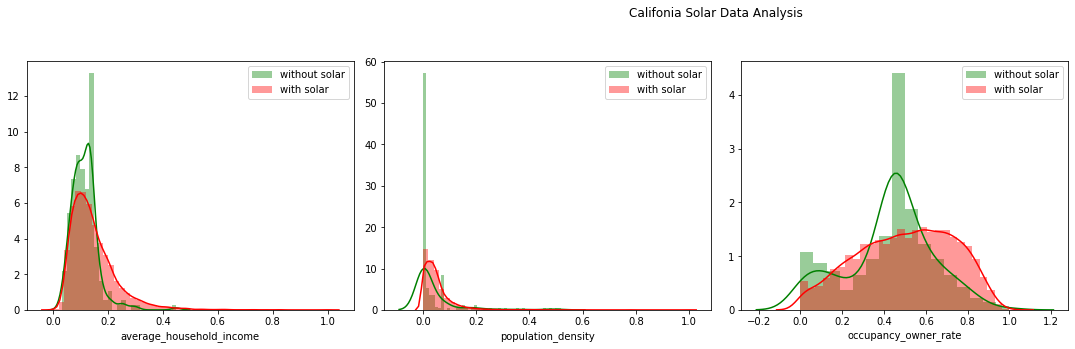

In [605]:
columns = ['average_household_income', 'population_density', 'occupancy_owner_rate']

fig = plt.figure(figsize = (20, 25))
j = 0
for i in columns:
    plt.subplot(6, 4, j+1)
    j += 1
    sns.distplot(class_data[i][class_data['prediction']==0], color='g', label = 'without solar')
    sns.distplot(class_data[i][class_data['prediction']==1], color='r', label = 'with solar')
    plt.legend(loc='best')
fig.suptitle('Califonia Solar Data Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [459]:

class_data = class_data[class_data['prediction'] == 1]
class_data.drop('prediction', axis=1)
class_data.shape

(7839, 67)

    ** Both algorithms has very good performance, however, random forest has slightly better performance
    
    ** Random Forest Classifier has classified our data records into areas with solar system and areas without
    
    ** In the following section, A REGRESSION ALGORITHM WILL BE APPLIED TO DATA RECORDS WITH SOLAR SYSTEMS ONLY 

## REGRESSION

    ** The solar system count has variable values distribution across counties in CA
    
    ** We are using the socio-economic and environmental variables for prediction
    
    ** In this analysis, we will focus on the number of solar systems in CA cencus tract areas

In [460]:
# Extracting the number of households and solar system count for the classified dataset

# Hence, only the data records with solar systems will be involved

# class_data index will help identify those tract areas with solar system

solar_sys_count_classified_data = data['solar_system_count'][class_data.index]

In [465]:
# Creating our label data for regression  -  NUMBER OF SOLAR SYSTEM COUNT PER HOUSEHOLD

target = solar_sys_count_classified_data 

In [466]:
## Igoring inf values introduced while dividing by zero

target[~np.isfinite( target )] = 0 
target.max()

1535.0

In [467]:
# CHECKING OUR CLASSIFIED DATA HAS THE SAME NUMBER OF ELEMENTS WITH THE LABELS WE JUST CREATE BASED ON IT

# AS WE CAN SEE BELOW, BOTH HAVE THE SAME NUMBER OF ELEMENTS

print("Based on Random Forest Classfier,", class_data.shape[0],"has solar systems." )
print("The labels just created for the classified data has", len(target), "elements.")

Based on Random Forest Classfier, 7839 has solar systems.
The labels just created for the classified data has 7839 elements.


### B. Split data into Training and Validation Subsets

     ** In this section, the classified dataset is split into train and validation subsets
     
                 ^^. 80% training subset
                 ^^. 20% validation subset

In [468]:
# Splitting the dataset into 80% training and 20% validation subsets

from sklearn.model_selection import train_test_split

X_train, X_validation, y_train, y_validation = train_test_split(class_data, target, test_size = 0.2, random_state = 42, shuffle = True)

## Training Regression Algorithms

### Support Vector Machines

In [ ]:
# 4) Support vector machines

from sklearn.svm import SVR

svm_reg=SVR()
svm_reg.fit(X_train,y_train)

In [ ]:
# Prediction and evaluating the SVR model

# A value of 99.12is fairly good but a lot worse than our random forest model

validation_pred=svm_reg.predict(X_validation)
print(rmse(y_validation,validation_pred))

In [ ]:
# Looking into the r2 score to evaluate the performance of SVR

r2_score(y_validation, validation_pred)

### Random Forest Regressor

In [469]:
param_distribs = {
        'n_estimators': randint(500, 1000),
        'max_features': randint(5, 10),
    }

forest_reg = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rf_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [470]:
cvres = rf_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

75.4606010089297 {'max_features': 8, 'n_estimators': 848}
76.51438845064216 {'max_features': 7, 'n_estimators': 571}
75.1333900271646 {'max_features': 9, 'n_estimators': 520}
77.23029550020087 {'max_features': 6, 'n_estimators': 966}
76.47914742415516 {'max_features': 7, 'n_estimators': 958}
75.16431518677958 {'max_features': 9, 'n_estimators': 599}
76.51475320398738 {'max_features': 7, 'n_estimators': 649}
75.06263908492025 {'max_features': 9, 'n_estimators': 757}
75.48512582185194 {'max_features': 8, 'n_estimators': 913}
77.24597605451852 {'max_features': 6, 'n_estimators': 691}


In [471]:
import math
def rmse(x,y): 
    return math.sqrt(((x-y)**2).mean())

In [472]:
# Prediction and evaluation of the prediction using mean rmse value on VALIDATION DATA

val_predict = rf_search.predict(X_validation)

print(rmse(y_validation, val_predict))

77.31287272884917


In [473]:
# Looking at the range of the target values - evaluating mean rmse values

# For the range of values ~1535, a mean value of 77 is very good.

target_range = target.max() - target.min()
target_range

1535.0

In [474]:
# Looking into r2 score to evaluate the performance of Random Forest Regressor

# r2_score of 0.587 is very good considering the range of values

r2_score(y_validation, val_predict)

0.5870359746595554

In [496]:
# save the model to disk

filename = 'rf_regression_model.sav'
joblib.dump(rf_search, filename)

['rf_regression_model.sav']

In [500]:
solar_sys_count_classified_data = solar_sys_count_classified_data.tolist()

In [504]:
# load the model from disk and predict
loaded_model = joblib.load(filename)
result = loaded_model.predict(class_data)
result

array([ 75.14002642,  90.1664465 ,  99.52840159, ...,  19.8678996 ,
        58.32496697, 192.53104359])

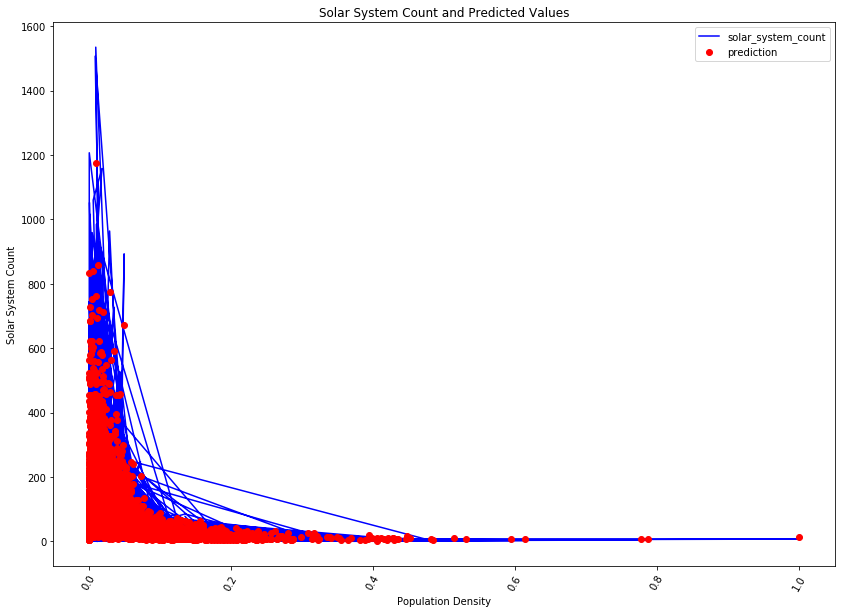

In [510]:
# Visual presentation of solar system count and predicted values

plt.figure(figsize=(14,10))

# Plot the actual values
plt.plot(class_data['population_density'], solar_sys_count_classified_data, 'b-', label = 'solar_system_count')

# Plot the predicted values
plt.plot(class_data['population_density'], result, 'ro', label = 'prediction')
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Population Density'); plt.ylabel('Solar System Count'); plt.title('Solar System Count and Predicted Values');

       ** In the above analysis, considerable effort has been made to build reliable prediction models
       
       ** These prediction models have very good result in both classification and regression areas
       
       ** These prediction models only apply to the State of California